This is a quick study to show how we can decorrelate a training that is heavily correlated on a variable. For this, we will perform a training on a 2D, imperfect space that has a strong correlation on one axis. We will output a contrastive space, where one dimension is the variable, we aim to predict and the other variable is explicitly decorrelated with that variable. We use a hybrid loss consisting of 

$$ \mathcal{L} = \mathcal{L}_{contrastive} + \mathcal{L}_{MSE}(y_{out},y_{axis})+ \mathcal{L}_{correlation}(x_{out}, y_{axis})$$

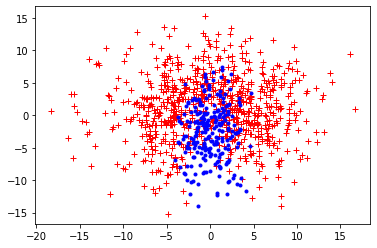

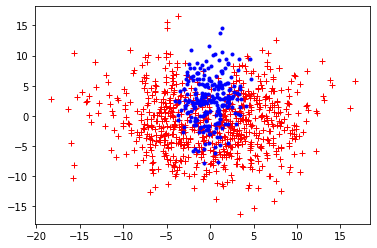

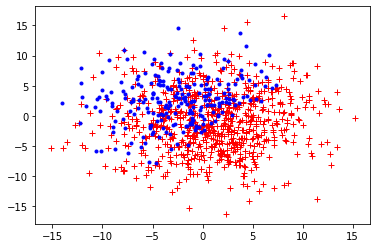

In [3]:
import numpy as np
import matplotlib.pyplot as plt

#sample
npoints=1000
#define points
x1 = np.random.normal(0, 5, npoints) #mean, sigma, num_points
x2 = np.random.normal(0, 5, npoints)
x3 = np.random.normal(0, 5, npoints)

#make a discriminator between two samples that is largely y-based (small x-y slope)
mask_pos = x2 >  (3. - x1*x1+x3)
mask_neg = x2 <= (3. - x1*x1+x3)

#now smear
noise = 0. #sets the noise scale
x1noise = np.random.normal(0, noise, npoints)
x2noise = np.random.normal(0, noise, npoints)
x3noise = np.random.normal(0, noise, npoints)
x1 = x1 + x1noise
x2 = x2 + x2noise
x3 = x3 + x3noise

# lets define a true boundary between the two classes
x1_pos = x1[mask_pos]
x2_pos = x2[mask_pos]
x3_pos = x3[mask_pos]
x1_neg = x1[mask_neg]
x2_neg = x2[mask_neg]
x3_neg = x3[mask_neg]

#plot the lot
plt.plot(x1_pos, x2_pos, 'r+')
plt.plot(x1_neg, x2_neg, 'b.')
x_list = [np.concatenate((x1_pos,x1_neg)),np.concatenate((x2_pos,x2_neg)),np.concatenate((x3_pos,x3_neg))]
y_list = [1.]*len(x1_pos) + [-1.]*len(x1_neg)
#y_list = [1.]*len(x1_pos) + [0]*len(x1_neg)
plt.show()

plt.plot(x1_pos, x3_pos, 'r+')
plt.plot(x1_neg, x3_neg, 'b.')
plt.show()

plt.plot(x2_pos, x3_pos, 'r+')
plt.plot(x2_neg, x3_neg, 'b.')
plt.show()

In [4]:
#now lets separate these guys with an NN to start with
import torch 

class simple_MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(3,1)
        self.output = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.output(x)
        return x
    

simple_model = simple_MLP()
print(simple_model.state_dict())


OrderedDict([('fc1.weight', tensor([[ 0.5416, -0.4322,  0.5399]])), ('fc1.bias', tensor([0.3585]))])


In [5]:
#now lets separate these guys with an NN to start with
import torch 

class simple_MLP_N1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(2,1)
        self.output = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.output(x)
        return x
    

simple_model_n1 = simple_MLP_N1()
print(simple_model_n1.state_dict())


OrderedDict([('fc1.weight', tensor([[-0.6461, -0.1591]])), ('fc1.bias', tensor([0.1553]))])


[1] loss: 2.5177  
[2] loss: 2.4691  
[3] loss: 2.4206  
[4] loss: 2.3722  
[5] loss: 2.3240  
[6] loss: 2.2759  
[7] loss: 2.2279  
[8] loss: 2.1802  
[9] loss: 2.1325  
[10] loss: 2.0851  
[11] loss: 2.0379  
[12] loss: 1.9908  
[13] loss: 1.9440  
[14] loss: 1.8974  
[15] loss: 1.8511  
[16] loss: 1.8051  
[17] loss: 1.7593  
[18] loss: 1.7139  
[19] loss: 1.6688  
[20] loss: 1.6240  
[21] loss: 1.5797  
[22] loss: 1.5357  
[23] loss: 1.4922  
[24] loss: 1.4492  
[25] loss: 1.4066  
[26] loss: 1.3646  
[27] loss: 1.3232  
[28] loss: 1.2823  
[29] loss: 1.2422  
[30] loss: 1.2027  
[31] loss: 1.1640  
[32] loss: 1.1260  
[33] loss: 1.0889  
[34] loss: 1.0527  
[35] loss: 1.0174  
[36] loss: 0.9831  
[37] loss: 0.9499  
[38] loss: 0.9178  
[39] loss: 0.8868  
[40] loss: 0.8570  
[41] loss: 0.8284  
[42] loss: 0.8011  
[43] loss: 0.7751  
[44] loss: 0.7505  
[45] loss: 0.7272  
[46] loss: 0.7052  
[47] loss: 0.6846  
[48] loss: 0.6654  
[49] loss: 0.6475  
[50] loss: 0.6309  
[51] loss

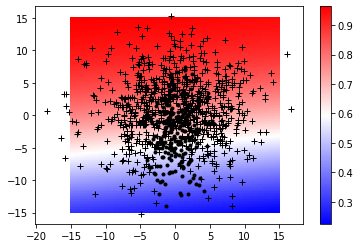

In [6]:
#Loss (Binary croos entry)
simple_criterion = torch.nn.BCELoss()
simple_optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.01) 
simple_history = {'loss':[]}

#formatting crap 
x_list_np = np.transpose(np.vstack((x_list[0],x_list[1],x_list[2])))
y_list_np = (np.array(y_list)+1)/2
x_torch=torch.from_numpy(x_list_np).float()
y_torch=torch.from_numpy(y_list_np.reshape(npoints,1)).float()

#train
for epoch in range(100):
    simple_optimizer.zero_grad()
    outputs = simple_model(x_torch)
    loss = simple_criterion(outputs, y_torch)
    loss.backward()
    simple_optimizer.step()    
    # add loss statistics
    current_loss = loss.item()
    print('[%d] loss: %.4f  ' % (epoch + 1,  current_loss))
    simple_history['loss'].append(current_loss)

outputs_optimal = simple_model(x_torch)
print('Finished Training')
#torch.save(simple_model.state_dict(), 'simple_model.pt')
#print(simple_model.state_dict())

#Now plot its perofmrance on a grid
x1_list = np.linspace(-15., 15., 100)
x2_list = np.linspace(-15., 15., 100)
x1_grid, x2_grid  = np.meshgrid(x1_list, x2_list)
x3_list = np.zeros(len(x2_grid.flatten()))
x_grid_np = np.transpose(np.vstack((x1_grid.flatten(),x2_grid.flatten(),x3_list)))
print(x_grid_np)
#x_grid_np = np.transpose(np.vstack((x1_grid.flatten(),x2_grid,x3_list)))
x_torch=torch.from_numpy(x_grid_np).float()
h_grid = simple_model(x_torch)
h_grid=h_grid.detach().numpy()
h_grid=h_grid.reshape(100,100)
plt.pcolormesh(x1_grid, x2_grid, h_grid, cmap = 'bwr', shading='auto')
plt.colorbar()

#now pot the points
plt.plot(x1_pos, x2_pos, 'k+')
plt.plot(x1_neg, x2_neg, 'k.')

plt.show()

[1] loss: 1.3756  
[2] loss: 1.3528  
[3] loss: 1.3304  
[4] loss: 1.3086  
[5] loss: 1.2872  
[6] loss: 1.2664  
[7] loss: 1.2462  
[8] loss: 1.2264  
[9] loss: 1.2072  
[10] loss: 1.1884  
[11] loss: 1.1701  
[12] loss: 1.1522  
[13] loss: 1.1346  
[14] loss: 1.1174  
[15] loss: 1.1003  
[16] loss: 1.0835  
[17] loss: 1.0667  
[18] loss: 1.0500  
[19] loss: 1.0334  
[20] loss: 1.0169  
[21] loss: 1.0004  
[22] loss: 0.9840  
[23] loss: 0.9676  
[24] loss: 0.9514  
[25] loss: 0.9353  
[26] loss: 0.9193  
[27] loss: 0.9036  
[28] loss: 0.8880  
[29] loss: 0.8726  
[30] loss: 0.8575  
[31] loss: 0.8427  
[32] loss: 0.8282  
[33] loss: 0.8140  
[34] loss: 0.8000  
[35] loss: 0.7864  
[36] loss: 0.7732  
[37] loss: 0.7602  
[38] loss: 0.7476  
[39] loss: 0.7353  
[40] loss: 0.7234  
[41] loss: 0.7117  
[42] loss: 0.7004  
[43] loss: 0.6894  
[44] loss: 0.6788  
[45] loss: 0.6685  
[46] loss: 0.6586  
[47] loss: 0.6490  
[48] loss: 0.6398  
[49] loss: 0.6310  
[50] loss: 0.6225  
[51] loss

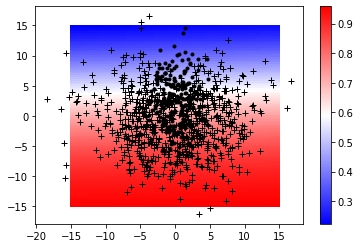

In [7]:
#Loss (Binary croos entry)
simple_criterion = torch.nn.BCELoss()
simple_optimizer = torch.optim.Adam(simple_model_n1.parameters(), lr=0.01) 
simple_history = {'loss':[]}

#formatting crap 
x_list_np = np.transpose(np.vstack((x_list[0],x_list[2])))
y_list_np = (np.array(y_list)+1)/2
x_torch=torch.from_numpy(x_list_np).float()
y_torch=torch.from_numpy(y_list_np.reshape(npoints,1)).float()

#train
for epoch in range(100):
    simple_optimizer.zero_grad()
    outputs = simple_model_n1(x_torch)
    loss = simple_criterion(outputs, y_torch)
    loss.backward()
    simple_optimizer.step()    
    # add loss statistics
    current_loss = loss.item()
    print('[%d] loss: %.4f  ' % (epoch + 1,  current_loss))
    simple_history['loss'].append(current_loss)

outputs_optimal_n1 = simple_model_n1(x_torch)
print('Finished Training')
#torch.save(simple_model.state_dict(), 'simple_model.pt')
#print(simple_model.state_dict())

#Now plot its perofmrance on a grid
x1_list = np.linspace(-15., 15., 100)
x3_list = np.linspace(-15., 15., 100)
x1_grid, x3_grid  = np.meshgrid(x1_list, x3_list)
x_grid_np = np.transpose(np.vstack((x1_grid.flatten(),x3_grid.flatten())))
#x_grid_np = np.transpose(np.vstack((x1_grid.flatten(),x2_grid,x3_list)))
x_torch=torch.from_numpy(x_grid_np).float()
h_grid = simple_model_n1(x_torch)
h_grid=h_grid.detach().numpy()
h_grid=h_grid.reshape(100,100)
plt.pcolormesh(x1_grid, x3_grid, h_grid, cmap = 'bwr', shading='auto')
plt.colorbar()

#now pot the points
plt.plot(x1_pos, x3_pos, 'k+')
plt.plot(x1_neg, x3_neg, 'k.')

plt.show()

In the next two boxes we define the new losses that we want to use. One is the contrastive loss, to build an embedded space and construct a distance within this embedded space. Here we will build a 2D embedded space. The next one after that is the decorrelation loss built from here(https://forum.numer.ai/t/differentiable-spearman-in-pytorch-optimize-for-corr-directly/2287/26)

In [8]:
import torch.nn as nn

class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
        #print((mask*log_prob).sum(1))
        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        
        return loss

In [9]:
#using some random library
from fast_soft_sort.pytorch_ops import soft_rank
#torchsort.soft_rank

#some failed attempts first
def corrcoef(target, pred):
    # np.corrcoef in torch from @mdo
    # https://forum.numer.ai/t/custom-loss-functions-for-xgboost-using-pytorch/960
    pred_n = pred - pred.mean()
    target_n = target - target.mean()
    pred_n = pred_n / pred_n.norm()
    target_n = target_n / target_n.norm()
    return (pred_n * target_n).sum()


def spearman(target,pred,regularization="l2",regularization_strength=1.0,):
    # fast_soft_sort uses 1-based indexing, divide by len to compute percentage of rank
    pred = soft_rank(pred,regularization=regularization,regularization_strength=regularization_strength,)
    return corrcoef(target, pred / pred.shape[-1])


def spearman_loss_lgb(ytrue, ypred):
    
    def corrcoef(target, pred):
        pred_n = pred - pred.mean()
        target_n = target - target.mean()
        pred_n = pred_n / pred_n.norm()
        target_n = target_n / target_n.norm()
        return (pred_n * target_n).sum()

    def differentiable_spearman(target, pred, regularization="l2", regularization_strength=1.0,):
        pred = soft_rank(pred,regularization=regularization,regularization_strength=regularization_strength,)
        return corrcoef(target, pred / pred.shape[-1])
    
    lenypred = ypred.shape[0]
    lenytrue = ytrue.shape[0]

    ypred_th = torch.tensor(ypred.reshape(1, lenypred), requires_grad=True)
    ytrue_th = torch.tensor(ytrue.reshape(1, lenytrue))

    loss = differentiable_spearman(ytrue_th, ypred_th, regularization_strength=1e-2)
    print(f'Current loss:{loss}')
    return 

    # calculate gradient and convert to numpy
    #loss_grads = torch.autograd.grad(loss, ypred_th)[0]
    #loss_grads = loss_grads.to('cpu').detach().numpy()

    # return gradient and ones instead of Hessian diagonal
    #return loss_grads[0], np.ones(loss_grads.shape)[0]
    
#now the final correlation loss    
class CorrLoss(nn.Module):
    def __init__(self, sort_tolerance=1.0,sort_reg='l2'):
        super(CorrLoss, self).__init__()
        self.tolerance = sort_tolerance
        self.reg       = sort_reg
    
    def spearman(self, pred, target):
        #print(pred.shape,target.shape)
        lenypred = pred.shape[0]
        lenytrue = target.shape[0]
        ypred_th = torch.tensor(pred  .reshape(1, lenypred), requires_grad=True)
        ytrue_th = torch.tensor(target.reshape(1, lenytrue))
        pred   = soft_rank(ypred_th,regularization=self.reg,regularization_strength=self.tolerance,)
        target = soft_rank(ytrue_th,regularization=self.reg,regularization_strength=self.tolerance,)
        #pred = torchsort.soft_rank(pred.reshape(1,-1),regularization_strength=x)
        #target = torchsort.soft_rank(target.reshape(1,-1),regularization_strength=x)
        pred = pred - pred.mean()
        pred = pred / pred.norm()
        target = target - target.mean()
        target = target / target.norm()
        ret = 1- (pred * target).sum()
        return ret
    
    def forward(self, features, labels):
        return self.spearman(features,labels)

/Users/pharris/Dropbox/Physics/DAZSLE/ContraDecorr/fast_soft_sort/third_party/isotonic.py:39: UserWarning: Numba could not be imported. Code will run much more slowly. To install, please run 'pip install numba'.
  warnings.warn("Numba could not be imported. Code will run much more slowly."


In [6]:
#skip this box
class simple_CLR(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(2,2)
        #self.output = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        #x = self.output(x)
        return x
    

simple_model = simple_CLR()
print(simple_model.state_dict())

OrderedDict([('fc1.weight', tensor([[ 0.2741, -0.4095],
        [-0.3665,  0.5870]])), ('fc1.bias', tensor([0.4511, 0.4954]))])


In [10]:
#skip this box
simple_criterion = SupConLoss()
simple_optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.01) 
simple_history = {'loss':[]}
x_list_np = np.transpose(np.vstack((x_list[0],x_list[1])))
y_list_np = (np.array(y_list)+1)/2
x_list_np = np.reshape(x_list_np,(npoints,1,2))
x_torch=torch.from_numpy(x_list_np).float()
y_torch=torch.from_numpy(y_list_np.reshape(npoints,1)).float()
#print(x1_pos[0],x2_pos[0],x_torch[0][0],x_torch[0][1],y_torch[0])
for epoch in range(1000):
    simple_optimizer.zero_grad()
    outputs = simple_model(x_torch)
    #print(outputs)
    loss = simple_criterion(outputs,y_torch)
    loss.backward()
    simple_optimizer.step()    
    # add loss statistics
    current_loss = loss.item()
    if epoch % 100 == 0: 
        print('[%d] loss: %.4f  ' % (epoch + 1,  current_loss))
    simple_history['loss'].append(current_loss)
            
print('Finished Training')
torch.save(simple_model.state_dict(), 'simple_model.pt')
print(simple_model.state_dict())

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1000x2 and 3x1)

(10000,)


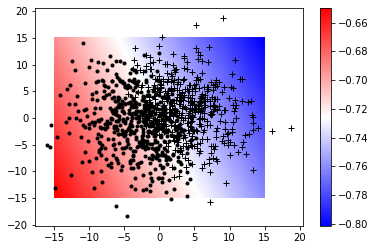

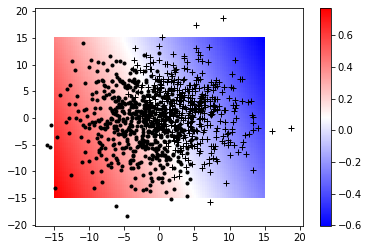

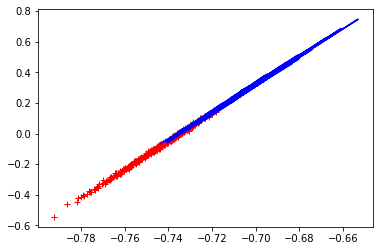

In [273]:
#this box plotting a working contrastive learning from above (skipped for now)
x_torch=torch.from_numpy(x_grid_np).float()
h_grid = simple_model(x_torch)
h_grid=h_grid.detach().numpy()
print(h_grid[:,0].shape)
h_gridx=h_grid[:,0].reshape(100,100)
plt.pcolormesh(x1_grid, x2_grid, h_gridx, cmap = 'bwr', shading='auto')
plt.colorbar()
plt.plot(x1_pos, x2_pos, 'k+')
plt.plot(x1_neg, x2_neg, 'k.')
plt.show()

h_gridy=h_grid[:,1].reshape(100,100)
plt.pcolormesh(x1_grid, x2_grid, h_gridy, cmap = 'bwr', shading='auto')
plt.colorbar()
plt.plot(x1_pos, x2_pos, 'k+')
plt.plot(x1_neg, x2_neg, 'k.')
plt.show()

x_torch=torch.from_numpy(x_list_np).float()
outputs = simple_model(x_torch)
plt.plot(outputs[y_torch > 0][:,0].detach().numpy(),outputs[y_torch > 0][:,1].detach().numpy(), 'k+',c='r')
plt.plot(outputs[y_torch == 0][:,0].detach().numpy(),outputs[y_torch == 0][:,1].detach().numpy(), 'k-',c='b')
plt.show()


In [13]:
#now lets build a full model and train it with our fancy loss
class test_CLR(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(3,10)
        self.act1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(10,2)
        self.act2 = torch.nn.ReLU()
        #self.output = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        #x = self.output(x)
        return x
    

test_model = test_CLR()
#print(test_model.state_dict())

In [20]:
#3 loss components
clr_criterion  = SupConLoss()
mse_criterion  = nn.MSELoss()
cor_criterion  = CorrLoss()
test_optimizer = torch.optim.Adam(test_model.parameters(), lr=0.0001) 
test_history = {'loss':[]}

#py torch stuff
x_list_np = np.transpose(np.vstack((x_list[0],x_list[1],x_list[2])))
y_list_np = (np.array(y_list)+1)*0.5
x_list_np = np.reshape(x_list_np,(npoints,1,3))
x_torch=torch.from_numpy(x_list_np).float()
y_torch=torch.from_numpy(y_list_np.reshape(npoints,1)).float()

#training 
for epoch in range(500):
    test_optimizer.zero_grad()
    outputs   = test_model(x_torch)
    loss_clr  = clr_criterion(outputs,y_torch)
    loss_mse  = mse_criterion(outputs[:,:,1:2],x_torch[:,:,1:2])
    loss_corr = cor_criterion(outputs[:,:,0:1],x_torch[:,:,1:2])
    #loss_mse2 = mse2_criterion(outputs[:,:,0:1],x_torch[:,:,1:2])
    #this is our super loss with 3 components
    loss = loss_clr+loss_mse+loss_corr
    loss.backward()
    test_optimizer.step()    
    # add loss statistics
    current_loss = loss.item()
    clr_loss  = loss_clr.item()
    mse_loss  = loss_mse.item()
    corr_loss = loss_corr.item() 
    if epoch % 100 == 0: 
        print('[%d] loss: %.4f %.4f %.4f %.4f ' % (epoch + 1,  current_loss, clr_loss, mse_loss, corr_loss))
    test_history['loss'].append(current_loss)
            
print('Finished Training')
#print(test_model.state_dict())

/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[1] loss: 33.2967 7.1510 25.0355 1.1101 
[101] loss: 33.2244 7.1571 24.9351 1.1322 
[201] loss: 33.1748 7.1742 24.8449 1.1556 
[301] loss: 33.0934 7.2203 24.6876 1.1854 
[401] loss: 32.9759 7.2661 24.4994 1.2104 
Finished Training


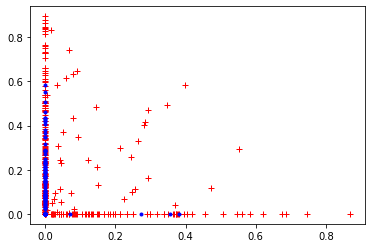

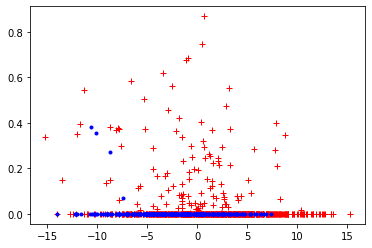

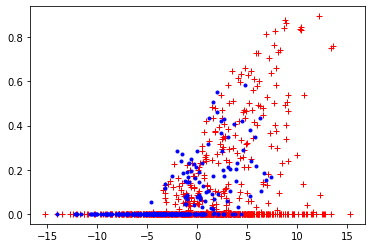

In [17]:
#now we plot it
x_torch=torch.from_numpy(x_list_np).float()
outputs = test_model(x_torch)

#This is the output space split by type
plt.plot(outputs[y_torch > 0][:,0].detach().numpy(),outputs[y_torch > 0][:,1].detach().numpy(), 'k+',c='r')
plt.plot(outputs[y_torch == 0][:,0].detach().numpy(),outputs[y_torch == 0][:,1].detach().numpy(), 'k.',c='b')
plt.show()

#This plot should NOT be correlated
plt.plot(x_torch[y_torch > 0][:,1].detach().numpy(),outputs[y_torch > 0][:,0].detach().numpy(), 'k+',c='r')
plt.plot(x_torch[y_torch == 0][:,1].detach().numpy(),outputs[y_torch == 0][:,0].detach().numpy(), 'k.',c='b')
plt.show()

#This plot should be correlated
plt.plot(x_torch[y_torch > 0][:,1].detach().numpy(),outputs[y_torch > 0][:,1].detach().numpy(), 'k+',c='r')
plt.plot(x_torch[y_torch == 0][:,1].detach().numpy(),outputs[y_torch == 0][:,1].detach().numpy(), 'k.',c='b')
plt.show()



In [18]:
#finally lets check it all
def compute_ROC(labels, predicts, npts=101):
    lMin = np.min(predicts)
    lMax = np.max(predicts)
    cutvals = np.linspace(lMin,lMax,num=npts)
    tot0 = float(len(labels[labels==0]))
    tot1 = float(len(labels[labels==1]))
    tpr = []
    fpr = []
    for c in cutvals:
        fpr.append(float(len(predicts[(labels==0) & (predicts>c)]))/tot0)
        tpr.append(float(len(predicts[(labels==1) & (predicts>c)]))/tot1)
    
    return np.array(fpr),np.array(tpr)

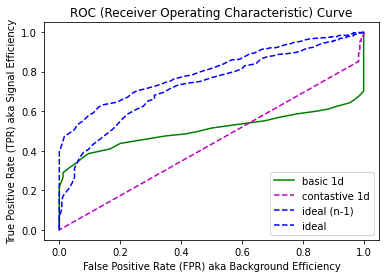

In [19]:
#now lets make our ROCs and see how we compare to the one that is not correlated (basic-1d) vs the ideal
roc_1d          = compute_ROC(y_list_np,x_torch[:,:,0].detach().numpy().flatten())
roc_1d_contrast = compute_ROC(y_list_np,-1.*outputs[:,:,0].detach().numpy().flatten())
roc_ideal       = compute_ROC(y_list_np,outputs_optimal_n1.detach().numpy().flatten())
roc_ideal_full  = compute_ROC(y_list_np,outputs_optimal.detach().numpy().flatten())

plt.plot(roc_1d[0],         roc_1d[1],'g-',label="basic 1d")
plt.plot(roc_1d_contrast[0],roc_1d_contrast[1],'m--',label="contastive 1d")
plt.plot(roc_ideal[0],      roc_ideal[1],'b--',label="ideal (n-1)")
plt.plot(roc_ideal_full[0],      roc_ideal_full[1],'b--',label="ideal")

plt.title("ROC (Receiver Operating Characteristic) Curve")
plt.xlabel("False Positive Rate (FPR) aka Background Efficiency")
plt.ylabel("True Positive Rate (TPR) aka Signal Efficiency")
plt.legend(loc="lower right")
plt.show()